In [505]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense, Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
from scikeras.wrappers import KerasRegressor  
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import metrics
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_addons as tfa

In [606]:
data=pd.read_csv("saved.csv")
data.drop(data.columns[0],axis=1,inplace=True)
train = pd.DataFrame(data[0:int(len(data)*0.90)])
train_y = train["targetClass"]
test = pd.DataFrame(data[int(len(data)*0.90): int(len(data))])
test_y = test["targetClass"]
train.drop(["target","targetClass"],axis=1, inplace=True)
test.drop(["target","targetClass"],axis=1, inplace=True)
columns=train.columns
train

,Volume,SMA14,WMA14,Momentum,ADO,STCK,STCD,LWR,RSI,CCI,Signal
0,106873020,13.417257,13.369057,-1.214464,0.330690,24.906533,1206.493417,75.093467,25.302781,-5.065139,-0.156614
1,96303600,13.392929,13.369879,-0.340591,0.372159,50.838694,1455.296008,49.161306,39.877998,37.340864,-0.152446
2,91096812,13.380631,13.363001,-0.172173,0.606017,39.277716,1696.364794,60.722284,44.314011,-0.683571,-0.147653
3,146029824,13.378629,13.385056,-0.028028,0.287895,74.791554,2171.249575,25.208446,49.154844,123.852263,-0.141348
4,81106812,13.371675,13.397068,-0.097347,0.896373,64.180918,2560.860845,35.819082,47.182390,106.170008,-0.134409
...,...,...,...,...,...,...,...,...,...,...,...
2915,15314000,142.807036,143.623047,7.861007,0.679174,75.345343,8576.897363,24.654657,77.155645,-8.659302,0.885718
2916,36840000,143.053215,143.365577,3.446503,0.965331,37.801527,8264.771668,62.198473,61.197605,-93.293175,0.850615
2917,22094000,143.216858,143.269482,2.291000,0.363232,33.708123,7881.075552,66.291877,58.047654,-103.308189,0.809565
2918,19674000,143.308500,143.179834,1.282990,0.507445,32.750017,7475.385270,67.249983,54.850275,-72.713723,0.765768


In [607]:
scaler=preprocessing.StandardScaler()
train=scaler.fit_transform(train)
test=scaler.transform(test)
train=pd.DataFrame(train,columns=columns)
test=pd.DataFrame(test,columns=columns)

In [608]:
train

,Volume,SMA14,WMA14,Momentum,ADO,STCK,STCD,LWR,RSI,CCI,Signal
0,0.891694,-1.031144,-1.031235,-0.664679,-0.489268,-1.112524,-2.202156,1.112524,-1.779461,-0.217939,-0.991146
1,0.681010,-1.032049,-1.031205,-0.348593,-0.350235,-0.254666,-2.083975,0.254666,-0.908587,0.221602,-0.974041
2,0.577222,-1.032507,-1.031460,-0.287675,0.433829,-0.637113,-1.969468,0.637113,-0.643533,-0.172524,-0.954370
3,1.672217,-1.032581,-1.030643,-0.235537,-0.632750,0.537716,-1.743898,-0.537716,-0.354292,1.118298,-0.928494
4,0.378089,-1.032840,-1.030198,-0.260610,1.407313,0.186707,-1.558833,-0.186707,-0.472147,0.935020,-0.900016
...,...,...,...,...,...,...,...,...,...,...,...
2915,-0.933378,3.783913,3.791212,2.617978,0.679102,0.556036,1.298777,-0.556036,1.318766,-0.255193,3.286631
2916,-0.504294,3.793074,3.781679,1.021223,1.638510,-0.685946,1.150517,0.685946,0.365267,-1.132429,3.142565
2917,-0.798230,3.799164,3.778121,0.603270,-0.380165,-0.821360,0.968262,0.821360,0.177057,-1.236235,2.974095
2918,-0.846469,3.802574,3.774802,0.238667,0.103341,-0.853055,0.775560,0.853055,-0.013988,-0.919121,2.794351


In [609]:
step_size = 10
num_samples = len(train) - step_size  
train = np.array([train[i : i + step_size] for i in range(num_samples)])  
train_y = np.array([train_y[i + step_size] for i in range(num_samples)])  
print("Shape of reshaped_train:",train.shape)  
print("Shape of reshaped_train_y:", train_y.shape)  

Shape of reshaped_train: (2910, 10, 11)
Shape of reshaped_train_y: (2910,)


In [610]:
num_test_samples = len(test) - step_size  
test = np.array(test)
test_y = np.array(test_y)
test = np.array([test[i : i + step_size] for i in range(num_test_samples)])
test_y = np.array([test_y[i + step_size] for i in range(num_test_samples)])

In [611]:
train.shape

(2910, 10, 11)

In [612]:
test.shape

(315, 10, 11)

In [613]:
def build_model(units_1=50, units_2=60, units_3=80, units_4=120, dropout_1=0.2, dropout_2=0.3, dropout_3=0.4, dropout_4=0.5, activation="relu"):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units_1, activation=activation, return_sequences=True, input_shape=(train.shape[1], train.shape[2]))))
    model.add(Dropout(dropout_1))
    model.add((Bidirectional(LSTM(units=units_2, activation=activation, return_sequences=True))))
    model.add(Dropout(dropout_2))
    model.add(LSTM(units=units_3, activation=activation, return_sequences=True))
    model.add(Dropout(dropout_3))
    model.add(LSTM(units=units_4, activation=activation))
    model.add(Dropout(dropout_4))
    model.add(Dense(units=1, activation="sigmoid"))  
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [727]:
model = Sequential()
model.add(Bidirectional(LSTM(units=60, activation="relu", return_sequences=True, input_shape=(train.shape[1], train.shape[2]),kernel_regularizer=tf.keras.regularizers.l2(0.009))))
model.add(Dropout(0.30))
model.add(LayerNormalization())
model.add(Bidirectional(LSTM(units=32, activation="relu", return_sequences=False,kernel_regularizer=tf.keras.regularizers.l2(0.009))))
model.add(Dense(units=1, activation="sigmoid"))  

In [728]:
checkpoint = ModelCheckpoint(
    filepath="best_model.h5",  
    monitor="val_accuracy",        
    save_best_only=True,           
    save_weights_only=True,
    mode="max",                  
    verbose=1
)

In [729]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [735]:
history = model.fit(train, train_y, 
                    validation_data=(test,test_y), 
                    epochs=100, 
                    batch_size=16, 
                    callbacks=[checkpoint])

Epoch 1/100
179/182 [============================>.] - ETA: 0s - loss: 0.5360 - accuracy: 0.7650
Epoch 1: val_accuracy did not improve from 0.61321
182/182 [==============================] - 2s 13ms/step - loss: 0.5354 - accuracy: 0.7667 - val_loss: 0.9593 - val_accuracy: 0.5377
Epoch 2/100
178/182 [============================>.] - ETA: 0s - loss: 0.5511 - accuracy: 0.7546
Epoch 2: val_accuracy did not improve from 0.61321
182/182 [==============================] - 2s 13ms/step - loss: 0.5527 - accuracy: 0.7533 - val_loss: 0.8980 - val_accuracy: 0.5000
Epoch 3/100
178/182 [============================>.] - ETA: 0s - loss: 0.5180 - accuracy: 0.7827
Epoch 3: val_accuracy did not improve from 0.61321
182/182 [==============================] - 2s 13ms/step - loss: 0.5173 - accuracy: 0.7838 - val_loss: 0.8972 - val_accuracy: 0.5377
Epoch 4/100
181/182 [============================>.] - ETA: 0s - loss: 0.5196 - accuracy: 0.7831
Epoch 4: val_accuracy did not improve from 0.61321
182/182 [===

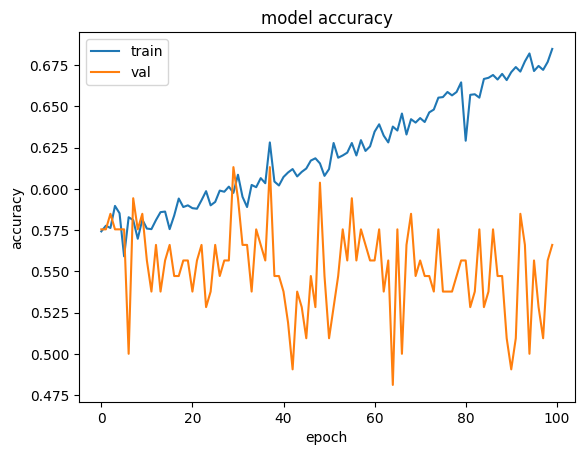

In [733]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

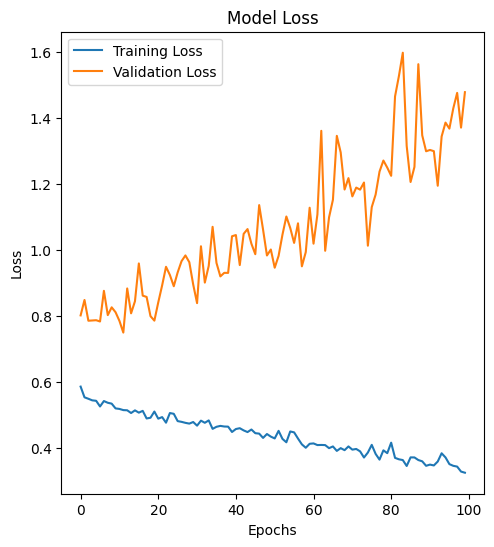

In [716]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [717]:
data=pd.read_csv("Google_Stock_Test (2023).csv")

In [718]:
def calculate_rsi(data, period=14):
    delta = data.diff()
    
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data["SMA14"]=data["Close"].rolling(window=14).mean()
data["WMA14"] = data["Close"].rolling(window=14).apply(lambda x: np.sum(range(1,15)*x) / 105, raw=False)
data["Momentum"]=data["Close"].diff(periods=14)
data["ADO"]=(data["High"]-data["Close"])/(data["High"]-data["Low"])
data["M"]=(data["High"]+data["Low"]+data["Close"])/3
data["SM"]=data["M"].rolling(window=10).mean()
data["LL14"]=data["Low"].rolling(window=14).min()
data["HH14"]=data["High"].rolling(window=14).max()
data["STCK"]=((data["Close"]-data["LL14"])/(data["HH14"]-data["LL14"]))*100
data["STCD"]=data["STCK"].rolling(window=14).mean()
data["STCD"]=100*data["STCD"]
data["LWR"]=((data["HH14"]-data["Close"])/(data["HH14"]-data["LL14"]))*100
data["RSI"]=calculate_rsi(data['Close'], period=14)
data["D"] = data["M"].rolling(window=14).apply(lambda x: abs(x - x.mean()).mean(), raw=False)
data["CCI"]=(data["M"]-data["SM"])/(0.015*data["D"])
data["EMA_Fast"] = data["Close"].ewm(span=12, adjust=False).mean()
data["EMA_Slow"] = data["Close"].ewm(span=16, adjust=False).mean()
data["MACD"] = data["EMA_Fast"] - data["EMA_Slow"]
data["Signal"] = data["MACD"].ewm(span=14, adjust=False).mean()

data["target"]=data["Adj Close"]-data["Open"]
data["target"]=data["target"].shift(-1)
data["targetClass"]=data["target"].apply(lambda x: 1 if x > 0 else 0)

data.dropna(inplace=True)
data.drop(["D","SM","M","HH14","LL14","MACD","EMA_Fast","EMA_Slow","Open","High","Low","Close","Adj Close","Date"], axis=1,inplace=True)
test=data
test_y = test["targetClass"]
data.drop(["target","targetClass"],axis=1, inplace=True)
columns=test.columns
test=scaler.transform(test)
test=pd.DataFrame(test,columns=columns)
num_test_samples = len(test) - step_size  
test = np.array(test)
test_y = np.array(test_y)
test = np.array([test[i : i + step_size] for i in range(num_test_samples)])
test_y = np.array([test_y[i + step_size] for i in range(num_test_samples)])

In [719]:
model.load_weights("best_model.h5")
prediction=model.predict(test)

4/4 [==============================] - 0s 4ms/step


In [720]:
binary_predictions = (prediction >= 0.5).astype(int)
accuracy = metrics.accuracy_score(test_y, binary_predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6320754716981132


In [ ]:
model = KerasRegressor(build_fn=build_model, dropout_1=0.2, dropout_2=0.3, dropout_3=0.4, dropout_4=0.5, units_1=50, units_2=60, units_3=80, units_4=120, activation="relu", verbose=0)

param_grid = {
    "dropout_1": [0.2, 0.3],
    "dropout_2": [0.3, 0.4],
    "dropout_3": [0.4, 0.5],
    "dropout_4": [0.5, 0.6], 
    "batch_size": [32, 64],
    "epochs": [50, 20]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train, train_y)


print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_}")

In [ ]:
best_model = grid_result.best_estimator_
history = best_model.fit(train, train_y, epochs=grid_result.best_params_['epochs'], batch_size=grid_result.best_params_['batch_size'], validation_split=0.1)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()